In [98]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [43]:
rows = pd.read_csv('data/rows for X.csv',header = None)

row_index = list(rows[0])

row_index = [val.lower() for val in row_index]

In [44]:
headers = pd.read_csv('data/columns for X.csv', header = None)

In [50]:
genes_to_keep = pd.read_csv('data/neurotransmitter genes 101020.csv', header = None)

In [51]:
genes_to_keep = list(genes_to_keep[0])

In [60]:
column_names = list(headers[0])

In [128]:
df_raw = pd.read_csv('data/X.csv',names = column_names, usecols = genes_to_keep)

In [145]:
df_raw.shape

(88031, 154)

Text(0.5, 1.0, 'percentage of 0s in columns - 153 subset of genes')

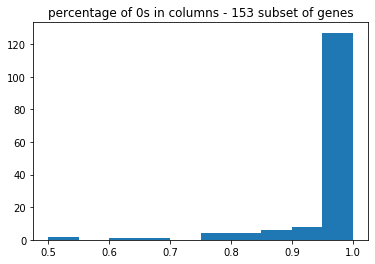

In [129]:
plt.hist((df_raw == 0).sum()/df_raw.shape[0])
plt.title('percentage of 0s in columns - 153 subset of genes')

In [130]:
df_raw.shape

(88031, 153)

In [131]:
df_raw.index = row_index
df_raw.reset_index(inplace=True)

In [132]:
df_raw = df_raw.rename({'index':'row_id'}, axis = 1)

In [155]:
df_raw.to_csv('data/unscaled_downselected_genes.csv',index = False)

In [133]:
df_raw['row_id'].value_counts()

tumor                    43817
fibroblast               17537
ductal                    6624
macrophages_monocytes     4775
endothelial               4591
atypical_ductal           3509
plasma                    1072
cd8pos_t                   925
b                          813
alpha                      760
beta                       631
cd4pos_t                   579
gamma                      468
smoothmuscle               361
nascentendothelial         343
cd4pos_tregs               323
schwann                    159
2591_t                     136
cdc2                       124
nk                         114
delta                       95
mast                        81
acinar                      66
dc_activated                62
cdc1                        55
pdc                         11
Name: row_id, dtype: int64

In [141]:
df_tumor_ductal = df_raw[(df_raw['row_id'] == 'tumor') | (df_raw['row_id'] == 'ductal')]

In [147]:
((df_tumor_ductal == 0).sum()/df_tumor_ductal.shape[0]).head()

row_id    0.000000
GABRD     0.997899
HTR6      0.999148
HTR1D     0.996431
GRIK3     0.994370
dtype: float64

In [213]:
from scipy.stats import ttest_ind
def t_test(x,y,alternative='both-sided'):
    _, double_p = ttest_ind(x,y,equal_var = False)
    if alternative == 'both-sided':
        pval = double_p
    elif alternative == 'greater':
        if np.mean(x) > np.mean(y):
            pval = double_p/2.
        else:
            pval = 1.0 - double_p/2.
    elif alternative == 'less':
        if np.mean(x) < np.mean(y):
            pval = double_p/2.
        else:
            pval = 1.0 - double_p/2.
    return pval

In [182]:
from scipy.stats import ttest_ind, chi2_contingency, fisher_exact

In [214]:
gene_list = []
ttest_pvalue_list = []
chisq_pvalue_list = []
fisher_pvalue_list = []
more_counts_list = []
for gene in genes_to_keep:
    tumor_values = df_tumor_ductal[df_tumor_ductal['row_id'] == 'tumor'][gene]
    ductal_values = df_tumor_ductal[df_tumor_ductal['row_id'] == 'ductal'][gene]
    
    ttest_pvalue = t_test(tumor_values, ductal_values, alternative = 'greater')
    
    tumor_zero_count = np.sum(tumor_values ==0) 
    tumor_nonzero_count = np.sum(tumor_values !=0) 
    
    ductal_zero_count = np.sum(ductal_values ==0) 
    ductal_nonzero_count = np.sum(ductal_values !=0) 
    
    contingency = [[tumor_zero_count,ductal_zero_count],
              [tumor_nonzero_count,ductal_nonzero_count]]

    if (ductal_nonzero_count == 0) and (tumor_nonzero_count == 0):
    
        chisq_pvalue = 'n/a - all values are zero'
        fisher_pvalue = 'n/a - all values are zero'

    else:
        _, chisq_pvalue, _,_ = chi2_contingency(contingency)
        _, fisher_pvalue = fisher_exact(contingency)

    if tumor_nonzero_count/tumor_zero_count > ductal_nonzero_count/ductal_zero_count:
        more_counts_list.append('tumor')
    else:
        more_counts_list.append('ductal')
        
    gene_list.append(gene)
    ttest_pvalue_list.append(ttest_pvalue)
    chisq_pvalue_list.append(chisq_pvalue)
    fisher_pvalue_list.append(fisher_pvalue)

In [215]:
df_test_results = pd.DataFrame(
{
    'gene': gene_list,
    'ttest_pvalue': ttest_pvalue_list,
    'chisq_pvalue':chisq_pvalue_list,
    'fisher_pvalue':fisher_pvalue_list,
    'greater_pct_nonzero':more_counts_list
}
)

In [216]:
np.round(df_test_results,5)

,gene,ttest_pvalue,chisq_pvalue,fisher_pvalue,greater_pct_nonzero
0,ADRA1A,0.02984,0.0464912,0.0336222,tumor
1,TH,0.00004,0.0723754,0.0367758,tumor
2,ADRA1B,0.00000,4.86668e-27,1.08076e-35,tumor
3,DDC,0.00547,0.00315705,0.000663395,tumor
4,ADRA1D,0.63181,0.881409,0.881942,tumor
5,DBH,0.74889,0.767786,1,tumor
6,ADRA2A,1.00000,1.41717e-12,1.77432e-11,ductal
7,COMT,1.00000,0.00380888,0.0039419,ductal
8,ADRA2B,0.00276,0.015766,0.00804405,tumor
9,MAOA,1.00000,6.3129e-05,6.74571e-05,ductal


In [217]:
df_test_results.to_csv('data/tumor_ductal_statistical_testing.csv',index=False)

In [197]:
df_test_results.corr()

,ttest_pvalue
ttest_pvalue,1.0


In [170]:
tumor_zero_count = np.sum(tumor_values ==0) 
tumor_nonzero_count = np.sum(tumor_values !=0) 

In [163]:
ductal_zero_count = np.sum(ductal_values ==0) 
ductal_nonzero_count = np.sum(ductal_values !=0) 

In [176]:
fisher_pvalue

3.2035655700848704e-10

In [164]:
a =chisquare([tumor_zero_count,tumor_nonzero_count], 
          [ductal_zero_count,ductal_nonzero_count])

In [167]:
[ductal_zero_count,ductal_nonzero_count]

[5649, 975]

In [168]:
[tumor_zero_count,tumor_nonzero_count]

[38589, 5228]

In [166]:
a.pvalue

0.0

In [158]:
ttest_pvalue_list

[0.05967257677551229,
 8.958695253501864e-05,
 4.214842311317609e-25,
 0.010947991486277255,
 0.7363845880183555,
 0.502218988614881,
 1.9041078873909612e-12,
 1.6586234653981813e-10,
 0.005527135620140885,
 4.3164016780375365e-24,
 0.00158070555199097,
 3.1184084613809764e-13,
 1.7500294030708924e-14,
 0.9382124444589741,
 0.6097905565008512,
 0.2245393464534893,
 0.49006126809567796,
 3.1559611691950946e-10,
 0.013458545532678143,
 nan,
 0.21326234370178299,
 0.3007760177221233,
 5.892776282700835e-48,
 0.03505798824919808,
 0.27444515109612416,
 2.361350219088139e-35,
 0.018630632166374245,
 0.38177173173958734,
 0.27661730061799916,
 0.4249737294898056,
 0.01479977275374996,
 2.002616970374695e-31,
 0.03555475355706397,
 0.947170898304817,
 0.27457085630631073,
 0.9070818142968443,
 7.24153247799781e-18,
 4.204898684327658e-18,
 nan,
 0.7136504854276975,
 0.5839137501396269,
 4.199820276415217e-15,
 0.39327584775472424,
 4.788614146766255e-47,
 1.957134331103591e-22,
 4.48115662769

# Scaling and downselection of tumor only genes

In [138]:
df_raw_tumor = df_raw[df_raw['row_id'] == 'tumor']

df_raw_tumor.to_csv('data/unscaled_tumor_downselected_genes.csv',index = False)

df_neurotrans_group = pd.read_csv('data/neurotransmitter_groups.csv')

df_neurotrans_group.head()

In [140]:
unique_neurotransmitters = df_neurotrans_group['Neurotransmitter Ligand'].unique()
unique_neurotransmitters

df_list = []
for neurotrans, df_neurotrans in df_neurotrans_group.groupby('Neurotransmitter Ligand'):
    gene_list = list(df_neurotrans['Genes'].unique())
    gene_list = [gene for gene in gene_list if gene in df_raw.columns]
    
    df_raw_subset = df_raw_tumor[gene_list]
    array_raw_subset = np.array(df_raw_subset)
    value_90th_percentile = np.percentile(array_raw_subset, q = 90)
    print(value_90th_percentile)
    